In [1]:
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime
from scipy.stats import stats
from scipy.stats import norm
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.proportion import proportions_ztest
import math
from collections import OrderedDict

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import auc




In [2]:
def train_test(df, start_date = '2009-4-30'):
    through2017 = df[df.Date <= '2018-01']

    #remove April 2009 data because there are a lot of nulls
    through2017 = through2017[through2017.Date > start_date]

    season2018 = df[df.Date > '2018-01']
    Xtrain = through2017.iloc[:,1:-1]
    #use 2018 season as test data
    Xtest = season2018.iloc[:,1:-1]
    ytrain = through2017.iloc[:,-1]
    ytest = season2018.iloc[:,-1]
    return Xtrain, Xtest, ytrain, ytest

def roc_auc(fit, Xtest, ytest):
    yprobs = fit.predict_proba(Xtest)[:,1]
    fpr, tpr, threshold = roc_curve(ytest,  yprobs)
    roc_auc = auc(fpr, tpr)
    print('AUC: ', roc_auc)

def plot_featimportances(forest, Xtrain, figname=None):
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
    indices = np.argsort(importances)[::-1]
    col_names = []

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(Xtrain.shape[1]):
        col_name = Xtrain.columns[indices[f]]
        print("%d. %s (%f)" % (f + 1, col_name, importances[indices[f]]))
        col_names.append(col_name)
        
    # Plot the feature importances of the forest
    plt.figure(figsize=(10,10))

    plt.title("Feature importances")
    plt.bar(range(Xtrain.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(Xtrain.shape[1]), Xtrain.columns[indices], rotation='vertical')
    plt.xlim([-1, Xtrain.shape[1]])
        
    if figname != None:
         plt.savefig(figname, dpi=300)
            
    return col_names

In [3]:
def plot_oob_errors(Xtrain, ytrain, figname = None):
    RANDOM_STATE = 123

    ensemble_clfs = [
        ("RandomForestClassifier, max_features='sqrt'",
            RandomForestClassifier(n_estimators=100,
                                   warm_start=True, oob_score=True,
                                   max_features="sqrt",
                                   random_state=RANDOM_STATE)),
        ("RandomForestClassifier, max_features='log2'",
            RandomForestClassifier(n_estimators=100,
                                   warm_start=True, max_features='log2',
                                   oob_score=True,
                                   random_state=RANDOM_STATE)),
        ("RandomForestClassifier, max_features=None",
            RandomForestClassifier(n_estimators=100,
                                   warm_start=True, max_features=None,
                                   oob_score=True,
                                   random_state=RANDOM_STATE))
    ]

    # Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
    error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

    # Range of `n_estimators` values to explore.
    min_estimators = 15
    max_estimators = 250

    for label, clf in ensemble_clfs:
        for i in range(min_estimators, max_estimators + 1):
            clf.set_params(n_estimators=i)
            clf.fit(Xtrain, ytrain)

            # Record the OOB error for each `n_estimators=i` setting.
            oob_error = 1 - clf.oob_score_
            error_rate[label].append((i, oob_error))

    # Generate the "OOB error rate" vs. "n_estimators" plot.
    for label, clf_err in error_rate.items():
        xs, ys = zip(*clf_err)
        plt.plot(xs, ys, label=label)

    plt.xlim(min_estimators, max_estimators)
    plt.xlabel("n_estimators")
    plt.ylabel("OOB error rate")
    plt.legend(loc="upper right")
    
    if figname != None:
         plt.savefig(figname, dpi=300)

In [4]:
infile = open('../PickledFiles/gamelogsRoll_ext', 'rb')
gamelogsRoll_ext = pickle.load(infile)
infile.close

infile = open('../PickledFiles/rel_cols', 'rb')
rel_cols = pickle.load(infile)
infile.close

infile = open('../PickledFiles/rel_diffs', 'rb')
diffs = pickle.load(infile)
infile.close

<function BufferedReader.close>

In [5]:
RANDOM_STATE = 123

In [6]:
Xtrain,Xtest,ytrain,ytest = train_test(gamelogsRoll_ext[rel_cols])

/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ens

/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ens

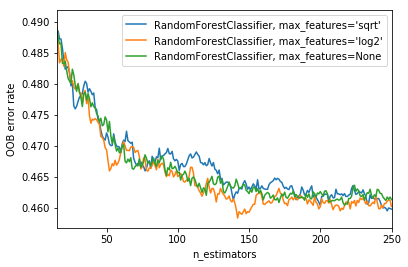

In [7]:
plot_oob_errors(Xtrain, ytrain, figname = 'OOB.png')

In [8]:

rf = RandomForestClassifier(n_estimators=500, max_features='sqrt',random_state=123)
rf.fit(Xtrain,ytrain)
ypreds = rf.predict(Xtest)

print("[Test Classification Report:]")
print(classification_report(ytest, ypreds))
print('Test Accuracy: ', accuracy_score(ypreds, ytest))
print('')
roc_auc(rf, Xtest, ytest)
#n_estimators = 500, max_feat = log2: test accuracy = 0.57384
#n_estimators = 500, max_feat = sqrt: test accuracy = 0.57466

[Test Classification Report:]
              precision    recall  f1-score   support

           0       0.58      0.36      0.44      1148
           1       0.57      0.77      0.66      1283

   micro avg       0.57      0.57      0.57      2431
   macro avg       0.58      0.56      0.55      2431
weighted avg       0.58      0.57      0.56      2431

Test Accuracy:  0.5746606334841629

AUC:  0.5913826207630744


Feature ranking:
1. AvgFIPnoConst_VSP (0.031472)
2. AvgFIPnoConst_HSP (0.030247)
3. AvgIP_HSP (0.028516)
4. AvgIP_VSP (0.027706)
5. AvgRunDiffOnRoad_V (0.026717)
6. AvgRelFIPnoConst_V (0.025792)
7. AvgPitchBABIP_H (0.025125)
8. AvgAper9_V (0.025109)
9. AvgOBP_V (0.025085)
10. AvgISO_V (0.025084)
11. AvgPitchBABIP_V (0.025077)
12. AvgRelFIPnoConst_H (0.024945)
13. AvgRunDiffAtHome_H (0.024941)
14. AvgOBP_H (0.024853)
15. AvgISO_H (0.024620)
16. AvgAttendance (0.024403)
17. AvgEper9_V (0.024200)
18. AvgEper9_H (0.024072)
19. AvgReliefIP_V (0.023823)
20. AvgReliefIP_H (0.023776)
21. AvgAper9_H (0.023764)
22. pctWminL_HSP (0.023688)
23. pctWminL_VSP (0.023172)
24. AvgSB_V (0.021017)
25. AvgSB_H (0.020862)
26. AvgDB_V (0.020839)
27. AvgGDP_V (0.020768)
28. AvgWP_HSP (0.020636)
29. AvgDB_H (0.020505)
30. AvgReliefWP_V (0.020271)
31. AvgWP_VSP (0.020247)
32. AvgGDP_H (0.020186)
33. AvgReliefWP_H (0.019937)
34. AvgCS_V (0.018886)
35. AvgSH_V (0.018804)
36. AvgSH_H (0.018763)
37. AvgSF_H (0.018

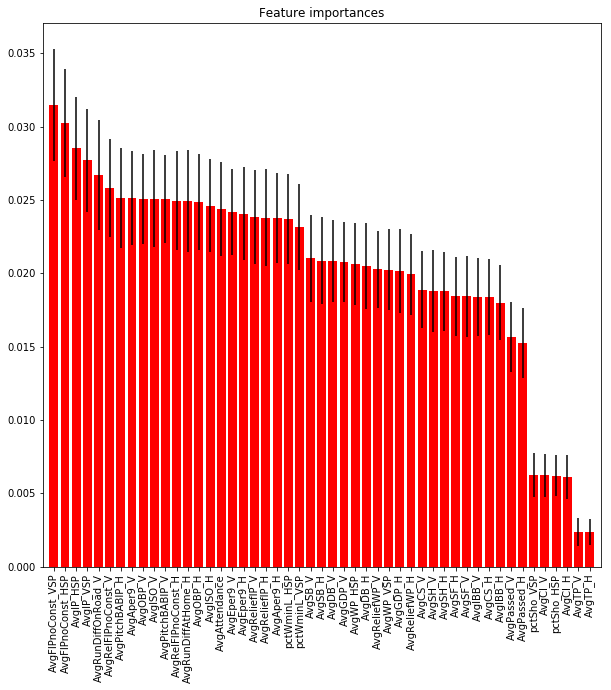

In [9]:
cols_imp_order = plot_featimportances(rf, Xtrain, figname = 'FeatImp.png')

In [10]:
#drop 16 least important features
#to_drop = ['pctSho_VSP','pctSho_HSP','AvgCI_V', 'AvgCI_H','AvgTP_V','AvgTP_H']
to_drop = cols_imp_order[-16:]
to_drop

['AvgCS_V',
 'AvgSH_V',
 'AvgSH_H',
 'AvgSF_H',
 'AvgSF_V',
 'AvgIBB_V',
 'AvgCS_H',
 'AvgIBB_H',
 'AvgPassed_V',
 'AvgPassed_H',
 'pctSho_VSP',
 'AvgCI_V',
 'pctSho_HSP',
 'AvgCI_H',
 'AvgTP_V',
 'AvgTP_H']

In [11]:
glRoll_rel = gamelogsRoll_ext[rel_cols]
glRoll_relsub = glRoll_rel.drop(to_drop, axis =1)

In [12]:
glRoll_relsub.shape

(24298, 35)

In [13]:
Xtrain_sub, Xtest_sub, ytrain, ytest = train_test(glRoll_relsub)

/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ens

/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ens

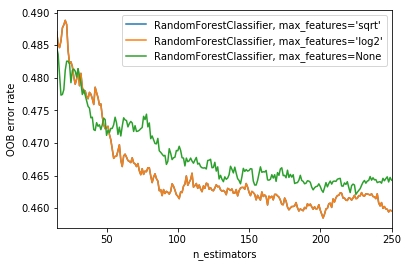

In [14]:
plot_oob_errors(Xtrain_sub, ytrain)

In [15]:

rfsub = RandomForestClassifier(n_estimators=500, max_features='log2',random_state=123)
rfsub.fit(Xtrain_sub,ytrain)
ypreds_sub = rfsub.predict(Xtest_sub)

print("[Test Classification Report:]")
print(classification_report(ytest, ypreds_sub))
print('Test Accuracy: ', accuracy_score(ypreds_sub, ytest))
print('')
roc_auc(rfsub, Xtest_sub, ytest)

[Test Classification Report:]
              precision    recall  f1-score   support

           0       0.58      0.37      0.45      1148
           1       0.58      0.76      0.65      1283

   micro avg       0.58      0.58      0.58      2431
   macro avg       0.58      0.57      0.55      2431
weighted avg       0.58      0.58      0.56      2431

Test Accuracy:  0.5767174002468121

AUC:  0.599557398953346


Feature ranking:
1. AvgFIPnoConst_VSP (0.037074)
2. AvgFIPnoConst_HSP (0.036572)
3. AvgIP_HSP (0.034227)
4. AvgIP_VSP (0.033513)
5. AvgRunDiffOnRoad_V (0.033160)
6. AvgRelFIPnoConst_V (0.032972)
7. AvgOBP_V (0.032247)
8. AvgRelFIPnoConst_H (0.032075)
9. AvgPitchBABIP_H (0.032029)
10. AvgISO_V (0.031992)
11. AvgISO_H (0.031901)
12. AvgPitchBABIP_V (0.031744)
13. AvgOBP_H (0.031607)
14. AvgAttendance (0.031494)
15. AvgRunDiffAtHome_H (0.031427)
16. AvgAper9_V (0.031373)
17. AvgEper9_H (0.031040)
18. AvgEper9_V (0.030968)
19. AvgReliefIP_H (0.030693)
20. AvgAper9_H (0.030557)
21. AvgReliefIP_V (0.030483)
22. pctWminL_HSP (0.028704)
23. pctWminL_VSP (0.027985)
24. AvgSB_V (0.027754)
25. AvgSB_H (0.027453)
26. AvgDB_V (0.026985)
27. AvgGDP_V (0.026892)
28. AvgDB_H (0.026701)
29. AvgGDP_H (0.026532)
30. AvgReliefWP_V (0.026015)
31. AvgReliefWP_H (0.025891)
32. AvgWP_VSP (0.024970)
33. AvgWP_HSP (0.024970)


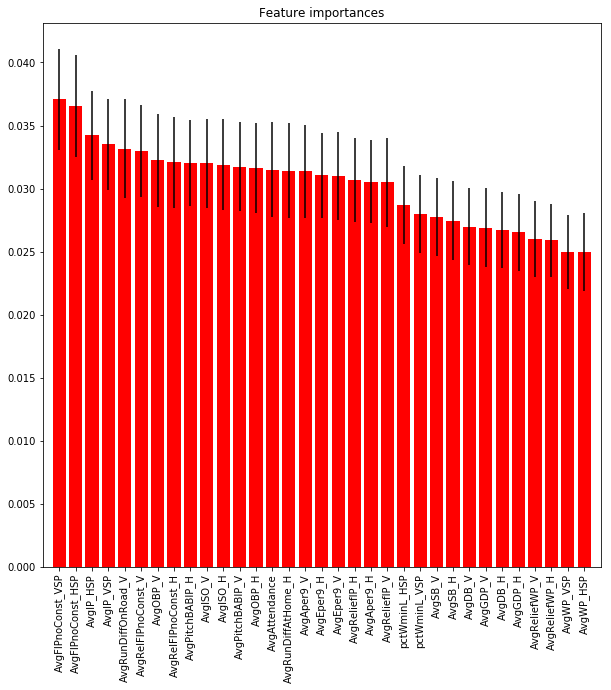

In [16]:
imp_cols_sub = plot_featimportances(rfsub, Xtrain_sub)

## Train a Model on Differences

In [18]:
Xtrain_diffs,Xtest_diffs,ytrain,ytest = train_test(gamelogsRoll_ext[diffs])

/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ens

/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ens

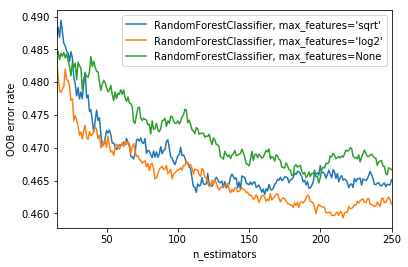

In [19]:

plot_oob_errors(Xtrain_diffs, ytrain, figname = 'OOB_diff.png')

In [20]:
rf_diffs= RandomForestClassifier(n_estimators=1000, max_features='log2', random_state = RANDOM_STATE)
rf_diffs.fit(Xtrain_diffs,ytrain)
ypreds_diffs = rf_diffs.predict(Xtest_diffs)

print("[Test Classification Report:]")
print(classification_report(ytest, ypreds_diffs))
print('Test Accuracy: ', accuracy_score(ypreds_diffs, ytest))
print('')
roc_auc(rf_diffs, Xtest_diffs, ytest)
#n_estimators=500, log2: test acc = 0.5771
#0.5837- class weight = bal

[Test Classification Report:]
              precision    recall  f1-score   support

           0       0.58      0.40      0.47      1148
           1       0.58      0.75      0.65      1283

   micro avg       0.58      0.58      0.58      2431
   macro avg       0.58      0.57      0.56      2431
weighted avg       0.58      0.58      0.57      2431

Test Accuracy:  0.5808309337721103

AUC:  0.5989623079617947


Feature ranking:
1. AvgFIPnoConst_SPdiff (0.052777)
2. AvgIP_SPdiff (0.049708)
3. AvgSpread_diff (0.048121)
4. AvgRelFIPnoConst_diff (0.047530)
5. AvgISO_diff (0.046883)
6. AvgOBP_diff (0.046459)
7. AvgPitchBABIP_diff (0.045460)
8. AvgAttendance (0.045268)
9. AvgAper9_diff (0.045088)
10. AvgEper9_diff (0.045008)
11. pctWminL_SPdiff (0.044404)
12. AvgReliefIP_diff (0.044074)
13. AvgWP_SPdiff (0.042468)
14. AvgSB_diff (0.040844)
15. AvgDB_diff (0.040575)
16. AvgGDP_diff (0.040154)
17. AvgReliefWP_diff (0.039574)
18. AvgSH_diff (0.039043)
19. AvgCS_diff (0.037605)
20. AvgIBB_diff (0.037597)
21. AvgSF_diff (0.037070)
22. AvgPassed_diff (0.033775)
23. AvgCI_diff (0.020793)
24. pctSho_SPdiff (0.020433)
25. AvgTP_diff (0.009289)


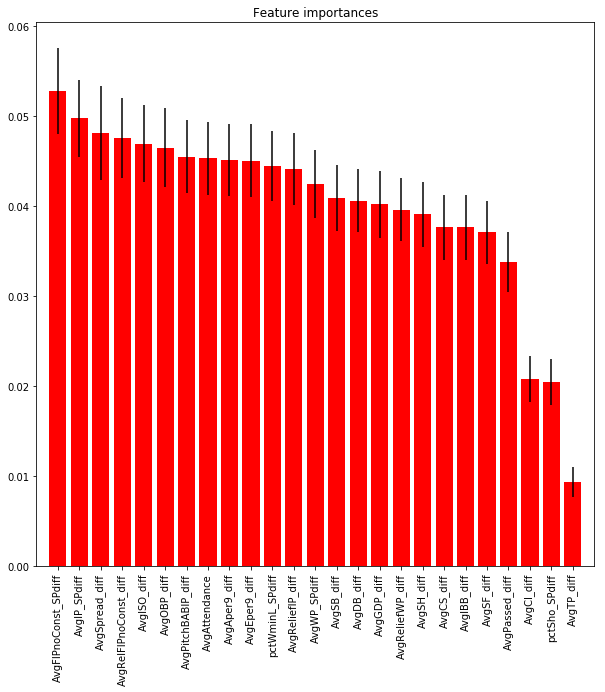

In [21]:
diff_cols_imp_order = plot_featimportances(rf_diffs, Xtrain_diffs, figname = 'FeatImp_diff.png')

In [22]:
#remove 6 least important features
to_drop = diff_cols_imp_order[-6:]
diff_df = gamelogsRoll_ext[diffs]
diff_df_sub = diff_df.drop(to_drop, axis=1)

In [23]:
Xtrain_diffsub, Xtest_diffsub, ytrain, ytest = train_test(diff_df_sub)

/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ens

/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/sklearn/ens

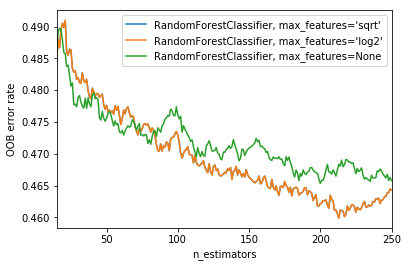

In [24]:
plot_oob_errors(Xtrain_diffsub, ytrain, figname = 'OOB_subdiff.png')

In [26]:
rf_diffsub= RandomForestClassifier(n_estimators=1000, max_features='log2', random_state = RANDOM_STATE)
rf_diffsub.fit(Xtrain_diffsub,ytrain)
ypreds_diffsub = rf_diffsub.predict(Xtest_diffsub)

print("[Test Classification Report:]")
print(classification_report(ytest, ypreds_diffsub))
print('Test Accuracy: ', accuracy_score(ypreds_diffsub, ytest))
print('')
roc_auc(rf_diffsub, Xtest_diffsub, ytest)
#test accuracy - drop last3, n_estimators = 1000,log2 - 0.5853

[Test Classification Report:]
              precision    recall  f1-score   support

           0       0.59      0.42      0.49      1148
           1       0.59      0.74      0.66      1283

   micro avg       0.59      0.59      0.59      2431
   macro avg       0.59      0.58      0.57      2431
weighted avg       0.59      0.59      0.58      2431

Test Accuracy:  0.5882352941176471

AUC:  0.6004736286089061


Feature ranking:
1. AvgFIPnoConst_SPdiff (0.061953)
2. AvgIP_SPdiff (0.058121)
3. AvgRelFIPnoConst_diff (0.056614)
4. AvgSpread_diff (0.056493)
5. AvgOBP_diff (0.055930)
6. AvgISO_diff (0.055465)
7. AvgAttendance (0.054452)
8. AvgPitchBABIP_diff (0.054446)
9. AvgEper9_diff (0.054011)
10. AvgAper9_diff (0.053998)
11. AvgReliefIP_diff (0.052579)
12. pctWminL_SPdiff (0.051767)
13. AvgWP_SPdiff (0.049907)
14. AvgSB_diff (0.049187)
15. AvgDB_diff (0.048317)
16. AvgGDP_diff (0.048008)
17. AvgReliefWP_diff (0.047380)
18. AvgSH_diff (0.046589)
19. AvgCS_diff (0.044783)


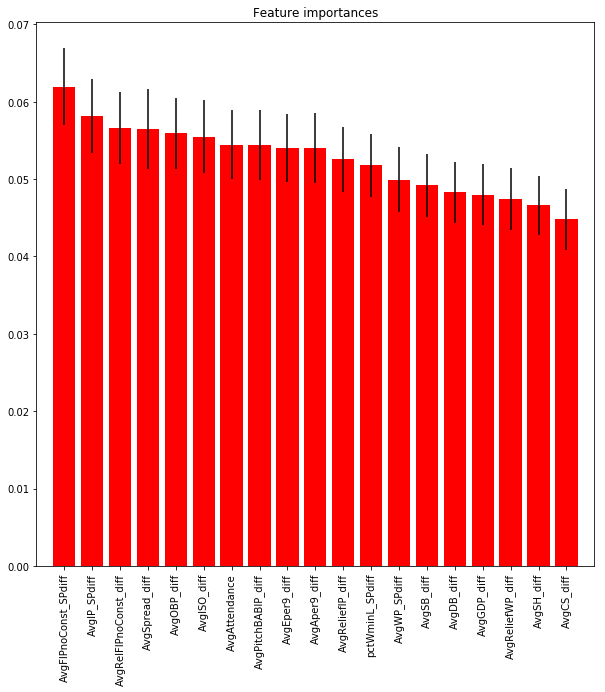

In [27]:
subdiff_cols_imp_order = plot_featimportances(rf_diffsub, Xtrain_diffsub)

In [28]:
#save results from 
yprobs = rf_diffsub.predict_proba(Xtest_diffsub)[:,1]
ypreds = rf_diffsub.predict(Xtest_diffsub)
RFprobs = pd.DataFrame({'prob_of_homewin_RF': yprobs,'pred_RF':ypreds, 'game_result': ytest})
RFprobs.head(10)

,prob_of_homewin_RF,pred_RF,game_result
21867,0.550,1,1
21868,0.518,1,1
21869,0.721,1,0
21870,0.461,0,0
21871,0.590,1,1
21872,0.484,0,0
21873,0.480,0,1
21874,0.669,1,0
21875,0.479,0,1
21876,0.350,0,1


In [29]:
#most important features chosen by RandomForest
imp_diffcols_RF = list(diff_df_sub.columns)

In [30]:
outfile = open('../PickledFiles/imp_diffcols_RF', 'wb')
pickle.dump(imp_diffcols_RF, outfile)
outfile.close()

outfile = open('../PickledFiles/RFprobs', 'wb')
pickle.dump(RFprobs, outfile)
outfile.close()